In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Step 25/100 completed
Step 50/100 completed
Step 75/100 completed
Step 100/100 completed
Simulation completed: 100 steps


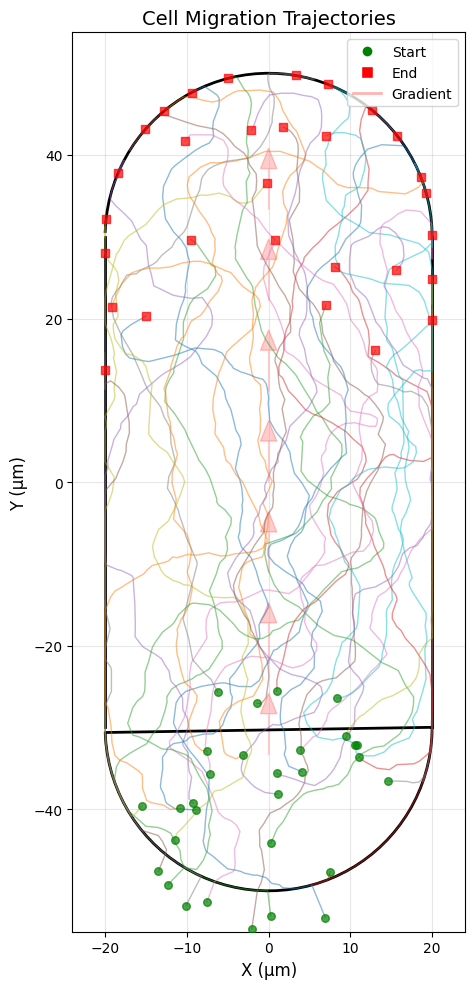

(<Figure size 600x1000 with 1 Axes>,
 <Axes: title={'center': 'Cell Migration Trajectories'}, xlabel='X (μm)', ylabel='Y (μm)'>)

In [2]:
from simulation import Simulation
from visualization import plot_trajectories

# Create simulation
sim = Simulation(
    n_cells=30,
    stadium_width=40,
    stadium_height=100,
    chemotaxis_strength=0.3,
    repulsion_strength=0.2
)

# Run simulation
sim.run(n_steps=100)

# Visualize
plot_trajectories(sim)

In [16]:
from analysis import fit_markov_chain
from scipy.stats import lognorm

# Load experimental data
data = pd.read_csv(r'D:\David\endoderm_migration\raw_data\220125_2DFACS_FOXA2positive_lateday2\tracks_df_220125_2DFACS_FOXA2positive_lateday2.csv')
data = data[['track_id', 'normalized_time', 'x_microns', 'y_microns']]
data = data.rename(columns={'normalized_time': 'step', 'x_microns': 'x', 'y_microns': 'y'})
data['dt'] = 10
data['dx'] = data.groupby('track_id')['x'].diff()
data['dy'] = data.groupby('track_id')['y'].diff()
data['v_x'] = data['dx'] / data['dt']
data['v_y'] = data['dy'] / data['dt']
data['velocity'] = np.sqrt(data['dx']**2 + data['dy']**2)/data['dt']
data['velocity'] = data['velocity'].replace([np.inf, -np.inf], np.nan)

# Fit lognormal distribution to velocities
data_velocity = data['velocity'].dropna().values
data_velocity = data_velocity[data_velocity > 0]  # Remove zero velocities
shape, loc, scale = lognorm.fit(data_velocity, floc=0)  # Fix location to 0 for log-normal

# Extract tracks
tracks = [group[['x', 'y']].values 
          for _, group in data.groupby('track_id')]

# Fit Markov chain
mc, B, n = fit_markov_chain(tracks, B=24, n=10)

# Use in simulation
sim = CellMigrationSimulation(
    markov_chain=mc,
    markov_params={'B': B, 'n': n},
    velocity_params= {'shape': shape, 'loc': loc, 'scale': scale},
    chemotaxis_strength=0.0,
    repulsion_strength=0.0
)

sim.run(n_steps=250)

Step 50/250 completed
Step 100/250 completed
Step 150/250 completed
Step 200/250 completed
Step 250/250 completed


d:\David\endoderm_migration\cell_migration_simulation\cell_migration_markov_agent_sim\MCmigrate\analysis.py:65: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(dot)
d:\David\endoderm_migration\cell_migration_simulation\cell_migration_markov_agent_sim\MCmigrate\analysis.py:65: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(dot)
d:\David\endoderm_migration\cell_migration_simulation\cell_migration_markov_agent_sim\MCmigrate\analysis.py:65: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(dot)


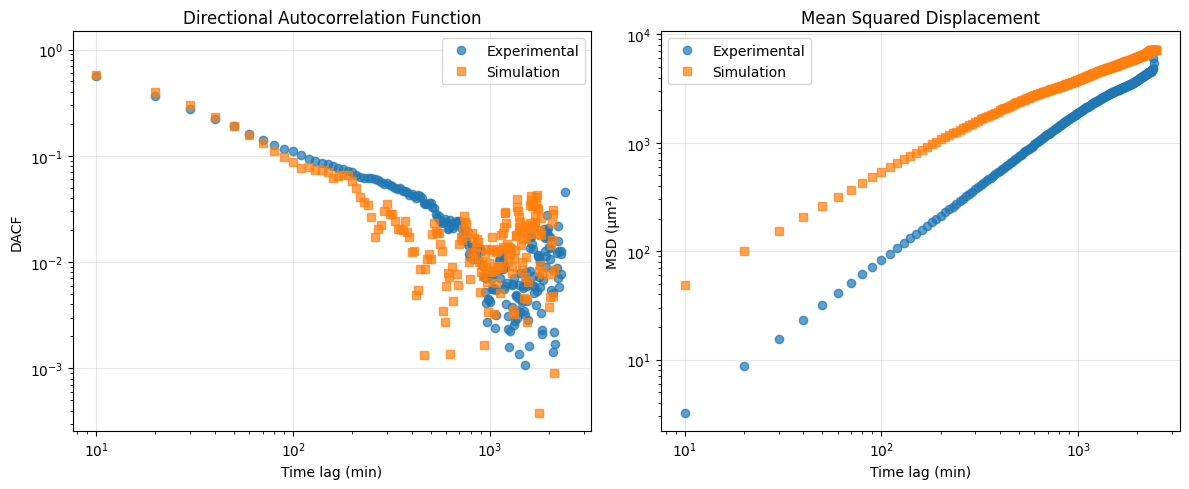

In [17]:
from analysis import calculate_autocorrelation, calculate_msd

# Get trajectory data
sim_df = sim.get_trajectories_dataframe()

# Calculate DACF
dacf = calculate_autocorrelation(sim_df, directional=True)

# Calculate MSD
msd = calculate_msd(sim_df)

# Prepare experimental data for comparison (add v_x, v_y if missing)
if 'v_x' not in data.columns or 'v_y' not in data.columns:
	data = data.copy()
	data['v_x'] = data['x'].diff()
	data['v_y'] = data['y'].diff()
	data.loc[data['track_id'] != data['track_id'].shift(), ['v_x', 'v_y']] = np.nan

data = data[:]  # Limit to first 500 rows for performance
# Compare with experimental data
from analysis import compare_metrics
results = compare_metrics(sim_df, data)

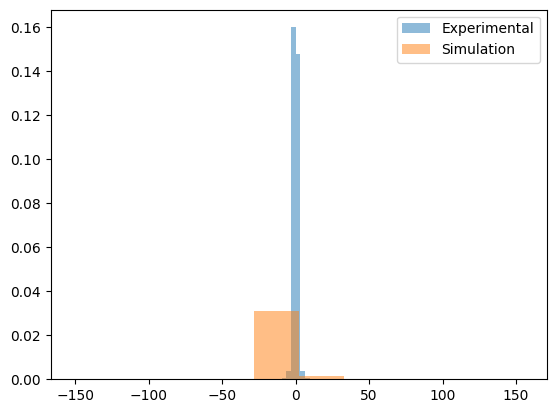

In [18]:
plt.hist(data['dx'].replace([np.inf, -np.inf], np.nan).dropna(), density=True, alpha=0.5, label='Experimental')
plt.hist(sim_df['dx'].replace([np.inf, -np.inf], np.nan).dropna(), alpha=0.5, density=True, label='Simulation')
plt.legend()

c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


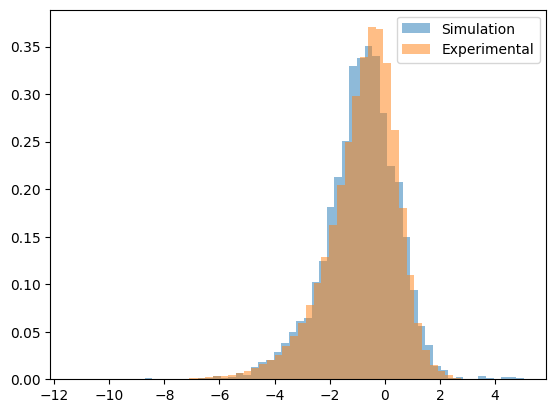

In [19]:
plt.hist(np.log(sim_df['dx']), bins=50, alpha=0.5, label='Simulation', density=True)
plt.hist(np.log(data['dx'].replace([np.inf, -np.inf, 0], np.nan).dropna()), bins=50, alpha=0.5, label='Experimental', density=True)

plt.legend()

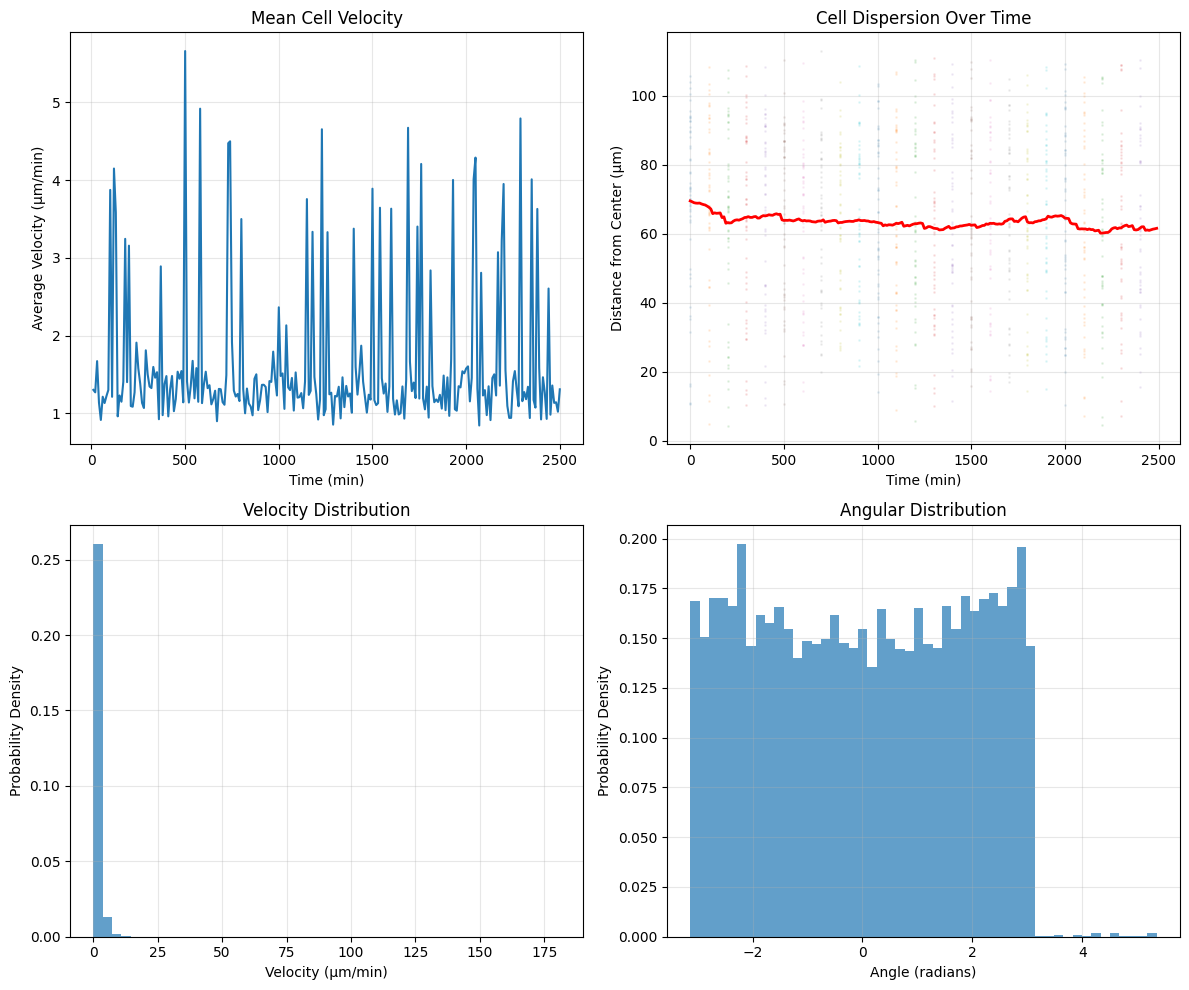

In [20]:
from visualization import SimulationVisualizer

viz = SimulationVisualizer(sim)

# Static trajectory plot
# viz.plot_trajectories(show_gradient=True)

# Statistics over time
viz.plot_statistics()

# Animated visualization
# anim = viz.create_animation(show_trails=True)
# anim.save('migration.gif', writer='pillow')